In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
import pandas as pd

from sklearn.metrics import confusion_matrix, classification_report

import sys
sys.path.append('../lib/')
from blood_lib import learning_curves

import tensorflow as tf
import tensorflow_addons as tfa

2023-06-11 21:44:42.610793: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/nicolas/miniconda3/envs/tf_amd/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
path = '../Data/PBC_6cat_masked/'

train_ds, val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(128, 128),
    labels='inferred',
    interpolation='bicubic',
    label_mode='categorical',
    validation_split=0.20,
    batch_size=32,
    subset='both',
    shuffle=True,
    seed=1
)
class_names = train_ds.class_names
num_classes = len(class_names)
train_ds, test_ds = tf.keras.utils.split_dataset(
    train_ds, left_size=0.8, seed=1)
print('train batch :', tf.data.Dataset.cardinality(train_ds).numpy())
print('val batch :', tf.data.Dataset.cardinality(val_ds).numpy())
print('test batch :', tf.data.Dataset.cardinality(test_ds).numpy())
print('classes :', class_names)
print('num_classes :', num_classes)


Found 10868 files belonging to 6 classes.
Using 8695 files for training.
Using 2173 files for validation.
Metal device set to: AMD Radeon Pro 570

systemMemory: 40.00 GB
maxCacheSize: 2.00 GB



2023-06-11 21:45:00.863715: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-06-11 21:45:00.863793: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-06-11 21:45:01.449203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [8695]
	 [[{{node Placeholder/_0}}]]
2023-06-11 21:45:01.450022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does 

train batch : 218
val batch : 68
test batch : 55
classes : ['basophil', 'eosinophil', 'erythroblast', 'lymphocyte', 'monocyte', 'platelet']
num_classes : 6


Calcul des class weights

In [3]:
# directory = Path(path)
# class_weights = {}
# total = len(list(directory.glob('**/*.png')))
# for i, class_name in enumerate(class_names):
#     #print(i, class_name)
#     len_i = len(list(Path(directory/class_name).glob('*.png')))
#     print(i, len_i)
#     weight_for_i = (1 / len_i) * (total / num_classes)
#     #print(weight_for_i)
#     class_weights[i] = weight_for_i
# class_weights


In [4]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(
            "horizontal_and_vertical", input_shape=(128, 128, 3)),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomBrightness(factor=0.001, value_range=(0, 255)),
        tf.keras.layers.RandomContrast(factor=0.1)
    ])


def process_images(ds, shuffle=1000, augment=False):
    """
    Apply diverse images modification in a tf.data.Dataset
    """
    # rescale
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    ds = ds.map(lambda x, y: (normalization_layer(x), y))
    # shuffle
    if shuffle != None:
        ds = ds.shuffle(shuffle)
    # augment
    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    return ds


train_ds = process_images(train_ds, shuffle=None, augment=False)
val_ds = process_images(val_ds, shuffle=None, augment=False)
test_ds = process_images(test_ds, shuffle=None, augment=False)


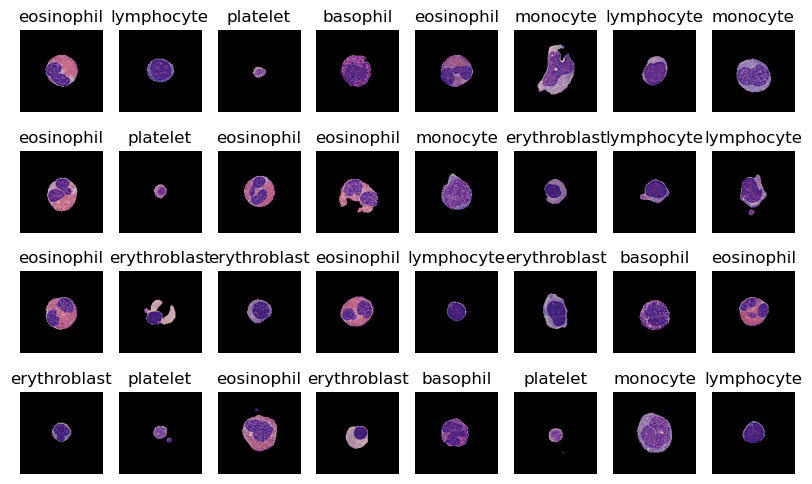

In [6]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 6))
for i in range(32):
    ax = plt.subplot(4, 8, i + 1)
    plt.imshow((image_batch[i].numpy() * 255).astype('uint8'))
    plt.title(class_names[np.argmax(label_batch[i])])
    plt.axis("off")


In [7]:
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from datetime import datetime

model = tf.keras.Sequential([
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

epochs = 50
log_dir = "logs/" + datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [EarlyStopping(monitor='val_loss', patience=5),
             TensorBoard(log_dir=log_dir, histogram_freq=1),
             tfa.callbacks.TQDMProgressBar()]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks,
    verbose=0
)


Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/218           ETA: ?s - 

2023-06-11 21:47:02.364880: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-06-11 21:47:29.537667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [2173]
	 [[{{node Placeholder/_0}}]]
2023-06-11 21:47:29.537948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2173]
	 [[{{node Placeholder/_4}}]]
2023-06-11 21:47:29.693695: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50


0/218           ETA: ?s - 

Epoch 3/50


0/218           ETA: ?s - 

Epoch 4/50


0/218           ETA: ?s - 

Epoch 5/50


0/218           ETA: ?s - 

Epoch 6/50


0/218           ETA: ?s - 

Epoch 7/50


0/218           ETA: ?s - 

Epoch 8/50


0/218           ETA: ?s - 

Epoch 9/50


0/218           ETA: ?s - 

Epoch 10/50


0/218           ETA: ?s - 

Epoch 11/50


0/218           ETA: ?s - 

Epoch 12/50


0/218           ETA: ?s - 

Epoch 13/50


0/218           ETA: ?s - 

Epoch 14/50


0/218           ETA: ?s - 

Epoch 15/50


0/218           ETA: ?s - 

Epoch 16/50


0/218           ETA: ?s - 

Epoch 17/50


0/218           ETA: ?s - 

Epoch 18/50


0/218           ETA: ?s - 

Epoch 19/50


0/218           ETA: ?s - 

Epoch 20/50


0/218           ETA: ?s - 

Epoch 21/50


0/218           ETA: ?s - 

Epoch 22/50


0/218           ETA: ?s - 

Epoch 23/50


0/218           ETA: ?s - 

Epoch 24/50


0/218           ETA: ?s - 

Epoch 25/50


0/218           ETA: ?s - 

Epoch 26/50


0/218           ETA: ?s - 

Epoch 27/50


0/218           ETA: ?s - 

Epoch 28/50


0/218           ETA: ?s - 

Epoch 29/50


0/218           ETA: ?s - 

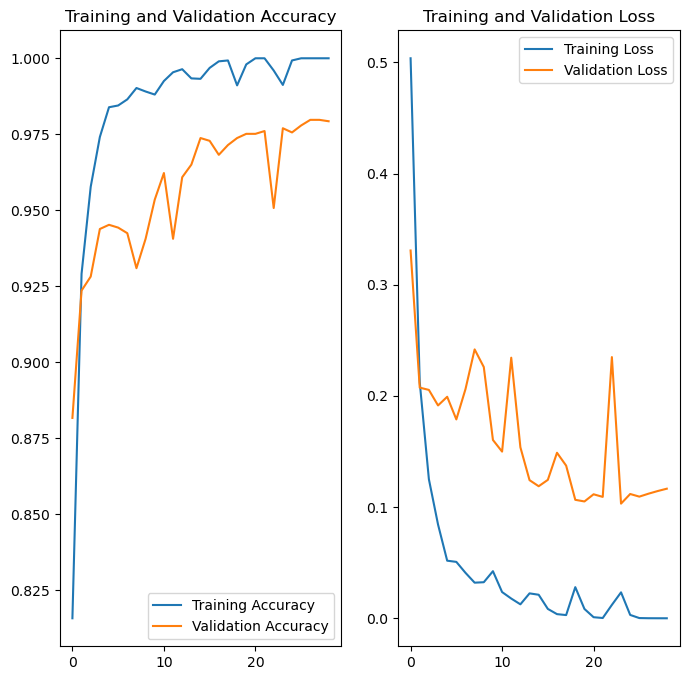

In [8]:
learning_curves(history)


2023-06-11 22:03:52.491828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [1739,6]
	 [[{{node Placeholder/_1}}]]
2023-06-11 22:03:52.597606: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


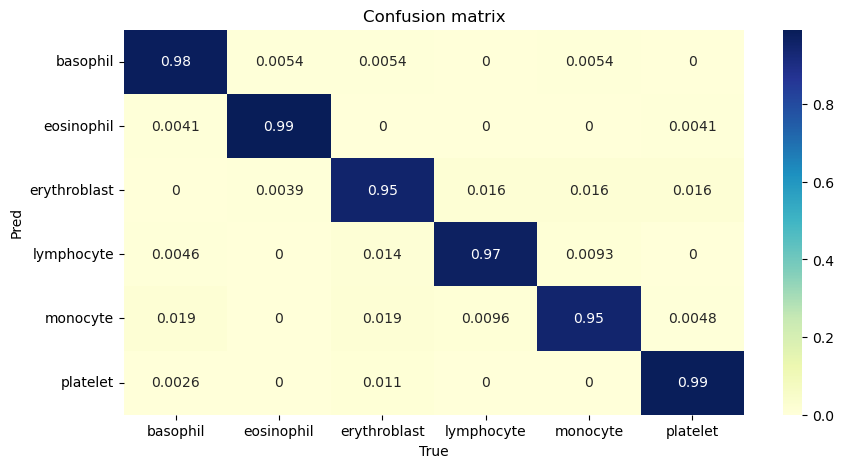

              precision    recall  f1-score   support

    basophil       0.96      0.98      0.97       186
  eosinophil       1.00      0.99      0.99       492
erythroblast       0.95      0.95      0.95       257
  lymphocyte       0.97      0.97      0.97       216
    monocyte       0.97      0.95      0.96       209
    platelet       0.98      0.99      0.98       379

    accuracy                           0.98      1739
   macro avg       0.97      0.97      0.97      1739
weighted avg       0.98      0.98      0.98      1739



In [9]:
from sklearn.metrics import confusion_matrix
preds = model.predict(test_ds, batch_size=32, verbose=0)
preds = np.argmax(preds, axis=1)
true = np.concatenate([y for x, y in test_ds], axis=0)
true = np.argmax(true, axis=1)
preds_labels = [class_names[preds[x]] for x in range(len(preds))]
true_labels = [class_names[true[x]] for x in range(len(true))]

cm = confusion_matrix(true_labels, preds_labels, normalize='true')
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
plt.figure(figsize=(10, 5))
plt.title("Confusion matrix")
sns.heatmap(cm_df, annot=True, cmap="YlGnBu")
plt.ylabel("Pred")
plt.xlabel("True")
plt.show()
CR = classification_report(true_labels, preds_labels)
print(CR)


In [10]:
model.save('Models/M0_PBC6_CNN3L_mask.h5')
with open('CR/CR_PBC6_CNN3L_mask.txt', 'w') as file:
    file.write(CR)
    file.close()
